## 기본설정 및 함수정의

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

# 영등포역 위도, 경도
ydp = [37.51569886583137, 126.90768824079629]

# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\geopandas\_compat.py:124: UserWarning:

The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\4035485422.py:23: DeprecationWarning:

Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using 

#### 영등포구 행정경계 (출처 - 통계지리정보서비스 2023년 센서스용 행정구역경계(읍면동))

In [2]:
# shp to geodataframe convert
shapefile_path = "SBJ_2406_001/_census_data_2023_bnd_dong_bnd_dong_11190_2023_2023\\bnd_dong_11190_2023_2023_2Q.shp"
ydp_gdf = gpd.read_file(shapefile_path)
ydp_gdf = ydp_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자(매핑용)

In [3]:
# GeoJSON 파일 불러오기
with open('SBJ_2406_001/19.영등포_격자(매핑용).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')

#### 영등포구 상세 도로망

In [4]:
# GeoJSON 파일 불러오기
with open('SBJ_2406_001/6.영등포_상세도로망.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : make_lin(x))
roadsystem_df['properties.link_id'] = roadsystem_df['properties.link_id'].astype(str)
roadsystem_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')

#### 도로명주소(도로)

In [5]:
# GeoJSON 파일 불러오기
with open('SBJ_2406_001/7.영등포_도로명주소(도로).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_df = pd.json_normalize(geojson_data['features'])
roadname_df['geometry.coordinates'] = roadname_df['geometry.coordinates'].apply(lambda x : make_lin(x))
roadname_df.rename(columns={'geometry.coordinates' : 'geometry'}, inplace=True)
# roadname_df 데이터프레임을 GeoDataFrame으로 변환
roadname_df = gpd.GeoDataFrame(roadname_df, geometry='geometry')

#### 소방용수시설 시각화

In [8]:
# 소방용수시설 데이터프레임을 GeoPandas 데이터프레임으로 변환
firefighting_water_df = pd.read_csv('SBJ_2406_001/22.영등포_소방용수시설.csv')
firefighting_water_df.dropna(inplace=True)
firefighting_water_df = geo_transform(firefighting_water_df)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 소방서 위치정보

In [9]:
# 소방서 데이터프레임을 GeoPandas 데이터프레임으로 변환
firehouse_df = pd.read_csv('SBJ_2406_001/23.영등포_소방서위치정보.csv')
firehouse_df = geo_transform(firehouse_df)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 출동현황(구조, 구급, 화재) -> 격자별 화재발생건수, 출동시간 변환

In [10]:
# 날짜와 시간을 결합하여 datetime 형식으로 변환하는 함수
def to_datetime(date, time):
    date_str = str(date)
    time_str = str(int(time)).zfill(6)  # 시간 형식이 6자리가 되도록 0을 앞에 추가
    datetime_str = f"{date_str} {time_str[:2]}:{time_str[2:4]}:{time_str[4:]}"
    return datetime.strptime(datetime_str, "%Y%m%d %H:%M:%S")

# 구조출동현황 데이터 로드 및 화재 필터링
helf_df = pd.read_csv('SBJ_2406_001/3.영등포_구조출동현황.csv')
helf_df = helf_df[helf_df['acdnt_cause'] == '화재']
helf_df = helf_df.dropna(subset=['dclr_ymd', 'dclr_tm', 'spt_arvl_ymd', 'spt_arvl_tm'])
helf_df['spt_arvl_ymd'] = helf_df['spt_arvl_ymd'].astype(int)
helf_df['spt_arvl_tm'] = helf_df['spt_arvl_tm'].astype(int)
# 신고 시각과 현장 도착 시각을 datetime 형식으로 변환
helf_df['dclr_datetime'] = helf_df.apply(lambda row: to_datetime(row['dclr_ymd'], row['dclr_tm']), axis=1)
helf_df['spt_arvl_datetime'] = helf_df.apply(lambda row: to_datetime(row['spt_arvl_ymd'], row['spt_arvl_tm']), axis=1)
# 신고 시각과 현장 도착 시각 사이의 시간 차이를 계산
helf_df['response_time'] = helf_df['spt_arvl_datetime'] - helf_df['dclr_datetime']
helf_df['response_time'] = helf_df['response_time'].dt.total_seconds() / 3600
helf_df = helf_df[helf_df['response_time'] > 0]
helf_df = helf_df[['lon', 'lat', 'response_time']]

# 구급출동현황 데이터 로드 및 화재 필터링
rescue_df = pd.read_csv('SBJ_2406_001/4.영등포_구급출동현황.csv')
rescue_df = rescue_df[rescue_df['ocrn_type_etc_detail_nm'].str.contains('화재', na=False)]
rescue_df = rescue_df.dropna(subset=['dclr_ymd', 'dclr_tm', 'spt_arvl_ymd', 'spt_arvl_tm'])
rescue_df['spt_arvl_ymd'] = rescue_df['spt_arvl_ymd'].astype(int)
rescue_df['spt_arvl_tm'] = rescue_df['spt_arvl_tm'].astype(int)
# 신고 시각과 현장 도착 시각을 datetime 형식으로 변환
rescue_df['dclr_datetime'] = rescue_df.apply(lambda row: to_datetime(row['dclr_ymd'], row['dclr_tm']), axis=1)
rescue_df['spt_arvl_datetime'] = rescue_df.apply(lambda row: to_datetime(row['spt_arvl_ymd'], row['spt_arvl_tm']), axis=1)
# 신고 시각과 현장 도착 시각 사이의 시간 차이를 계산
rescue_df['response_time'] = rescue_df['spt_arvl_datetime'] - rescue_df['dclr_datetime']
rescue_df['response_time'] = rescue_df['response_time'].dt.total_seconds() / 3600
rescue_df = rescue_df[['lon', 'lat', 'response_time']]

# 화재출동현황 데이터 로드
fire_df = pd.read_csv('SBJ_2406_001/21.영등포_화재출동현황.csv')
fire_df['response_time'] = pd.to_timedelta(fire_df['dsp_rqr_tm']).dt.total_seconds() / 3600
fire_df = fire_df[['lon', 'lat', 'response_time']]

# firefighting_df 데이터프레임 생성 후 GeoDataFrame으로 변환
firefighting_df = pd.concat([helf_df, rescue_df, fire_df])
firefighting_df = geo_transform(firefighting_df)
firefighting_df = gpd.GeoDataFrame(firefighting_df, geometry='geometry')

# 공간 조인 수행
joined = gpd.sjoin(firefighting_df, grid_map_df, how="inner", op='within')
# 각 격자 내의 화재발생 포인트 개수 계산
grid_fire_counts = joined.groupby(joined.index_right).size()
# 결과를 grid_map_df에 추가
grid_map_df['fire_count'] = grid_fire_counts
# NaN 값을 0으로 대체
grid_map_df['fire_count'] = grid_map_df['fire_count'].fillna(0)
# 평균 도착 시간을 계산할 새로운 열 생성
grid_map_df['rescue_time'] = 0.0  # 초기값 설정

# 공간 조인을 수행하여 rbuilding_df의 'geometry'가 grid_map_df의 'geometry'에 포함되는 행들을 찾습니다.
joined = gpd.sjoin(firefighting_df, grid_map_df, how="inner", op="within")
# 각 grid_map_df의 'geometry'별로 'use_weight'의 평균을 계산합니다.
mean_weights = joined.groupby('index_right')['response_time'].mean()
# 원래 grid_map_df에 'response_time' 열을 추가하고, 계산된 평균 값을 할당합니다.
grid_map_df['rescue_time'] = grid_map_df.index.map(mean_weights)
# NaN 값을 0으로 대체
grid_map_df['rescue_time'] = grid_map_df['rescue_time'].fillna(0)

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\3994671560.py:24: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be re

#### 격자별 소방시설 거리계산

In [11]:
# 격자의 중심점 좌표 추출
grid_coords = np.array(list(zip(grid_map_df.geometry.centroid.x, grid_map_df.geometry.centroid.y)))

##### 소방서 거리계산(KNN)

In [12]:
from sklearn.neighbors import NearestNeighbors
# 소방서의 좌표 추출
firehouse_coords = np.array(list(zip(firehouse_df.geometry.x, firehouse_df.geometry.y)))

# KNN 모델 생성 및 학습 (k=1 사용하여 가장 가까운 소방서 찾기)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(firehouse_coords)

# 각 격자와 가장 가까운 소방서 간의 거리 계산
distances, indices = knn.kneighbors(grid_coords)

# 거리를 km 단위로 변환 (EPSG:4326의 경우, 1도 ≈ 111,000m이므로 111을 곱하여 km단위로 변환)
distances_km = distances * 111

# 결과를 DataFrame에 추가
grid_map_df['nearest_firehouse_distance_weight'] = distances_km

##### 소방용수시설 거리계산(KNN)

In [13]:
from sklearn.neighbors import NearestNeighbors
# 소방용수시설의 좌표 추출
firefighting_water_coords = np.array(list(zip(firefighting_water_df.geometry.x, firefighting_water_df.geometry.y)))

# KNN 모델 생성 및 학습 (k=1 사용하여 가장 가까운 소방용수시설 찾기)
knn = NearestNeighbors(n_neighbors=3)
knn.fit(firefighting_water_coords)

# 각 격자와 가장 가까운 소방용수시설 간의 거리 계산
distances, indices = knn.kneighbors(grid_coords)

# 각 격자에 대해 Neighbors 개수만큼 거리의 평균 계산
avg_distances = np.mean(distances, axis=1)

# 거리를 km 단위로 변환 (EPSG:4326의 경우, 1도 ≈ 111,000m이므로 111을 곱하여 km단위로 변환)
distances_km = avg_distances * 111

# 결과를 DataFrame에 추가
grid_map_df['nearest_firefighting_water_distance_weight'] = distances_km

#### 주차민원위치정보

In [14]:
parking_petition_df = pd.read_csv('SBJ_2406_001/30.영등포_주차민원위치정보.csv')
parking_petition_df = geo_transform(parking_petition_df)

# 공간 조인 수행
joined = gpd.sjoin(parking_petition_df, grid_map_df, how="inner", op='within')
# 각 격자 내의 불법 주정차 점 개수 계산
grid_parking_counts = joined.groupby(joined.index_right).size()
# 결과를 grid_map_df에 추가
grid_map_df['parking_petition_count'] = grid_parking_counts
# NaN 값을 0으로 대체
grid_map_df['parking_petition_count'] = grid_map_df['parking_petition_count'].fillna(0)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\619703896.py:5: UserWarning:

CRS mismatch betw

#### 불법주정차 단속이력 시각화

In [15]:
illegal_parking_df = pd.read_csv('SBJ_2406_001/24.영등포_불법주정차단속이력.csv')
illegal_parking_df = geo_transform(illegal_parking_df)

# 공간 조인 수행
joined = gpd.sjoin(illegal_parking_df, grid_map_df, how="inner", op='within')
# 각 격자 내의 불법 주정차 점 개수 계산
grid_illegal_parking_counts = joined.groupby(joined.index_right).size()
# 결과를 grid_map_df에 추가
grid_map_df['illegal_parking_count'] = grid_illegal_parking_counts
# NaN 값을 0으로 대체
grid_map_df['illegal_parking_count'] = grid_map_df['illegal_parking_count'].fillna(0)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\3060736572.py:5: UserWarning:

CRS mismatch bet

#### 격자별 유동인구

In [25]:
floating_population_df_D = pd.read_csv('SBJ_2406_001/29.영등포_요일별_유동인구.csv')

floating_population_df_D['STD_YM'] = floating_population_df_D['STD_YM'].astype(str)
floating_population_df_D['STD_YM'] = floating_population_df_D['STD_YM'].apply(lambda x:x[:4])

# 열 이름 변경 과정
columns_to_rename = floating_population_df_D.columns[1:-2] # 시계열 정보를 포함한 column만 선택
new_column_names = []
# 각 열 이름을 처리하여 새로운 열 이름을 생성
for column_name in columns_to_rename:
    day_part = column_name.split('_')[0] # 숫자 부분 추출
    new_column_names.append(day_part) # new_column_names에 추가
# 열 이름을 변경합니다.
floating_population_df_D.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
floating_population_df_D =floating_population_df_D.iloc[:,1:]
floating_population_df_D = floating_population_df_D.groupby(['lon', 'lat']).mean().reset_index()

# 평일 및 주말 평균 계산
def calculate_weekday_weekend_means(df):
    # 평일 평균 = 1
    df['1'] = df[['mon', 'tue', 'wed', 'thu', 'fri']].mean(axis=1)
    # 주말 평균 = 2
    df['2'] = df[['sat', 'sun']].mean(axis=1)
    return df[['lon', 'lat', '1', '2']]

floating_population_df_D = calculate_weekday_weekend_means(floating_population_df_D)

# long 형식으로 변환
floating_population_df_D = floating_population_df_D.melt(
    id_vars=['lon', 'lat'],
    value_vars=['1', '2'],
    var_name='day_type',
    value_name='population'
)

# 'lon'과 'lat'가 같은 행들끼리 그룹화한 후 'population'의 평균을 계산
floating_population_df = floating_population_df_D.groupby(['lon', 'lat'])['population'].mean().reset_index()
floating_population_df = geo_transform(floating_population_df)
floating_population_df = gpd.GeoDataFrame(floating_population_df, geometry='geometry')
# 공간 조인을 수행
joined = gpd.sjoin(floating_population_df, grid_map_df, how="inner", op="within")
# 각 grid_map_df의 'geometry'별로 'population'의 평균을 계산
mean_weights = joined.groupby('index_right')['population'].mean()

# 원래 grid_map_df에 'average_g_usage' 열을 추가하고, 계산된 평균 값을 할당
grid_map_df['floating_population'] = grid_map_df.index.map(mean_weights)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\2880752910.py:41: UserWarning:

CRS mismatch be

#### 격자별 교통량

In [36]:
# 도로 id와 geometry를 매핑한 딕셔너리 생성 : 추정교통량 data와 매핑 예정
road_geo_dic = dict(zip(roadsystem_df['properties.link_id'], roadsystem_df['geometry']))

traffic_df = pd.read_csv('SBJ_2406_001/5.영등포_추정교통량.csv')
traffic_df['year'] = traffic_df['year'].astype(str)
traffic_df['link_id'] = traffic_df['link_id'].astype(str)
traffic_df['link_id'] = traffic_df['link_id'].apply(lambda x : x[:-2])
traffic_df = traffic_df[traffic_df['timeslot'] == 'all'] # 일별 누적교통량 사용
traffic_df['geometry'] = traffic_df['link_id'].map(road_geo_dic)
traffic_df = gpd.GeoDataFrame(traffic_df, geometry='geometry')

# 'lon'과 'lat'가 같은 행들끼리 그룹화한 후 'population'의 평균을 계산
traffic_df = traffic_df.groupby(['link_id', 'geometry', 'road_length'])['ALL_AADT'].mean().reset_index()
traffic_df = gpd.GeoDataFrame(traffic_df, geometry='geometry')
traffic_df

C:\Users\HJK\AppData\Local\Temp\ipykernel_2008\3085927880.py:4: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



,link_id,geometry,road_length,ALL_AADT
0,477685740,"LINESTRING (126.88894 37.54080, 126.88909 37.5...",8.853,19361.000000
1,477792723,"LINESTRING (126.90732 37.52546, 126.90647 37.5...",6.137,21557.000000
2,478600023,"LINESTRING (126.90706 37.49153, 126.90735 37.4...",0.100,4396.500000
3,478600024,"LINESTRING (126.90750 37.49043, 126.90732 37.4...",0.037,925.000000
4,478600032,"LINESTRING (126.90593 37.48912, 126.90627 37.4...",0.038,16651.500000
...,...,...,...,...
2986,928710875,"LINESTRING (126.91101 37.50585, 126.91120 37.5...",0.170,13715.833333
2987,928713797,"LINESTRING (126.92374 37.53136, 126.92398 37.5...",0.080,17408.500000
2988,928717434,"LINESTRING (126.92547 37.53082, 126.92539 37.5...",0.034,10567.000000
2989,928729599,"LINESTRING (126.90223 37.51646, 126.90245 37.5...",0.019,787.000000


In [40]:
# 공간 조인을 수행
joined = gpd.sjoin(traffic_df, grid_map_df, how="inner", op="intersects")
# 각 grid_map_df의 'geometry'별로 'average_g_usage'의 평균을 계산
mean_weights = joined.groupby('index_right')['ALL_AADT'].mean()

# 원래 grid_map_df에 'average_g_usage' 열을 추가하고, 계산된 평균 값을 할당
grid_map_df['traffic'] = grid_map_df.index.map(mean_weights)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



#### K-Means Clustering 활용 소방차진입난이도 도출

In [48]:
# 유동인구 column을 기준으로 하위 75% 이하인 값을 NaN 값을 포함하여 75% 값으로 대체
threshold = grid_map_df['floating_population'].quantile(0.25)
grid_map_df['floating_population'] = grid_map_df['floating_population'].apply(lambda x: threshold if pd.isna(x) or x <= threshold else x)
# 평균 전기 & 가스 사용량 column을 기준으로 하위 100% 이하인 값을 NaN 값을 포함하여 100% 값으로 대체
threshold = grid_map_df['traffic'].quantile(0.0)
grid_map_df['traffic'] = grid_map_df['traffic'].apply(lambda x: threshold if pd.isna(x) or x <= threshold else x)

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable O

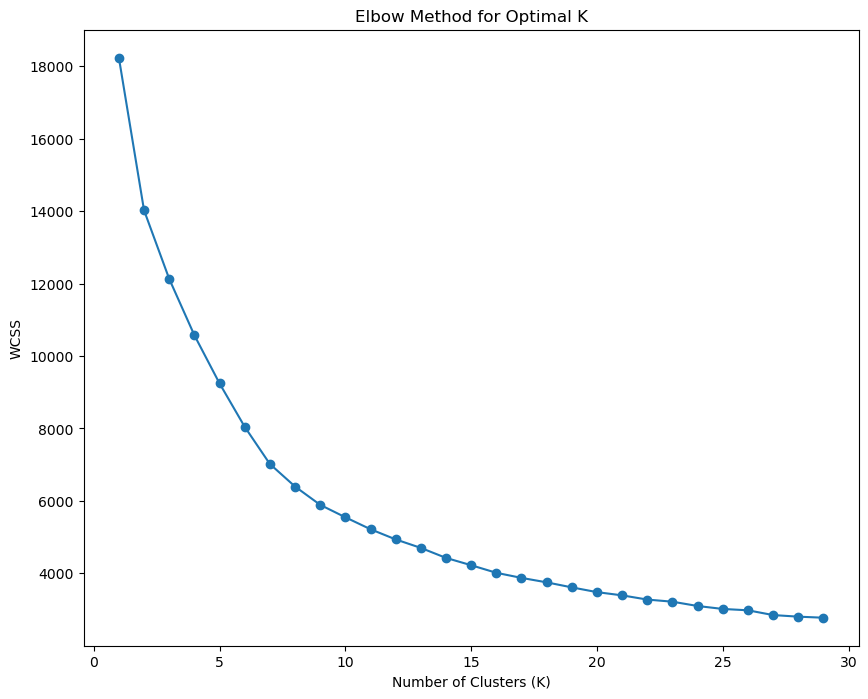

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 데이터 준비 (예시로 간단하게 특성을 설정합니다)
features = grid_map_df[grid_map_df.columns[5:]]

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 클러스터 개수 범위 설정
k_range = range(1, 30)

# 각 클러스터 개수에 대한 WCSS 계산
wcss = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# 엘보우 방법을 위한 그래프 그리기
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


In [54]:
# 적절한 클러스터 개수를 엘보우 그래프를 통해 확인합니다.
optimal_k = 11  # 예시로 5를 선택합니다. 실제 그래프를 보고 결정하세요.

# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# 클러스터링 결과 확인
grid_map_df['cluster'] = kmeans.labels_

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.



In [ ]:
#### 격자별 가중치 시각화
# 맵 객체 생성 및 데이터 로드
weight_map = KeplerGl(height=800)
weight_map.add_data(data=roadname_df, name="영등포구 도로망 데이터")
weight_map.add_data(data=ydp_gdf, name="영등포구 행정동 데이터")
weight_map.add_data(data=grid_map_df, name="소방차 진입난이도 데이터")
weight_map

In [58]:
# 맵 출력 및 상세설정
weight_map.save_to_html(file_name="visualization/소방차진입난이도 시각화 keplerGL.html")

Map saved to visualization/소방차진입난이도 시각화 keplerGL.html!


In [59]:
# 화재취약 군집번호 필터링
grid_map_vulnerable = grid_map_df[grid_map_df['cluster'] >= 6]
grid_map_vulnerable = grid_map_vulnerable[['properties.gid', 'geometry', 'cluster']]
grid_map_vulnerable.rename(columns={'properties.gid': 'gid'}, inplace=True)
grid_map_vulnerable.to_csv("visualization/소방차진입 난이도 높은지역.csv", index=False)

In [ ]:
#### 격자별 가중치 시각화
# 맵 객체 생성 및 데이터 로드
vulnerable_map = KeplerGl(height=800)
vulnerable_map.add_data(data=grid_map_vulnerable, name="소방차진입 난이도 높은지역")
vulnerable_map.add_data(data=ydp_gdf, name="영등포구 행정동 데이터")
vulnerable_map